It is time to implement a training function and pretrain the LLM. We will also implement basic model eval techniques to measure the quality of the generated text which is required for optimizing the LLM during training.


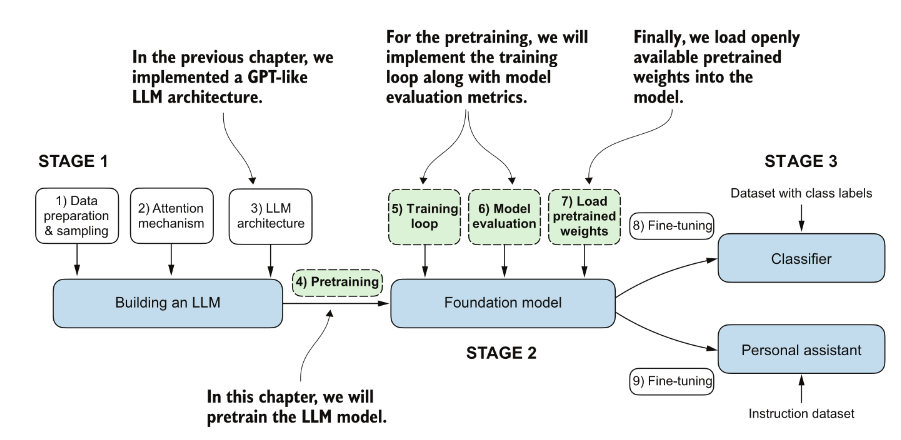

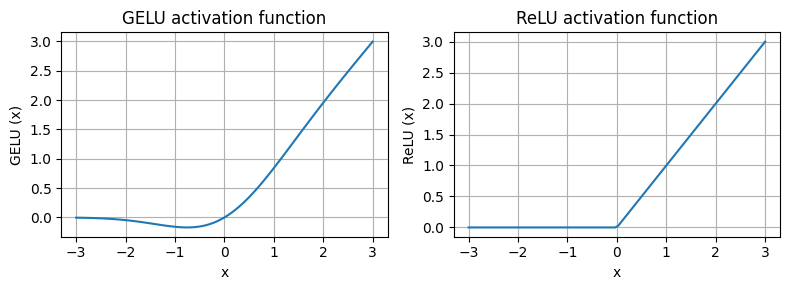

/home/mb/Documents/dev/llm_from_scratch/attention_mechanism.py:428: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (d_out % num_heads == 0, "d_out must be divisible by num_heads")


2.9.1+cu128
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights:  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum:  tensor(1.0000)
Input batch: tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape torch.Size([2, 4, 50257])
tensor([[[ 0.3612,  0.4223, -0.0712,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1793, -0.5660, -0.9486,  ...,  0.0477,  0.5181, -0.3169],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1017, -0.4326, -0.2553],
         [-1.0076,  0.3419, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2565,  0.0901,  0.0335,  ...,  0.2658,  0.4454, -0.6806],
         [ 0.1229,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2245],
         [ 1.0558,  1.0318, -0.2799,  ...,  0.6935,  0.3205, -0.3178],
         [-0.1567,  0.3928,  0.3288,  ...,  1.2630, -0.1859,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)
Number of trainable parameters in the GPT-2 model with weight tying: 124412160


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention

In [1]:
import torch
from llm_architecture import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

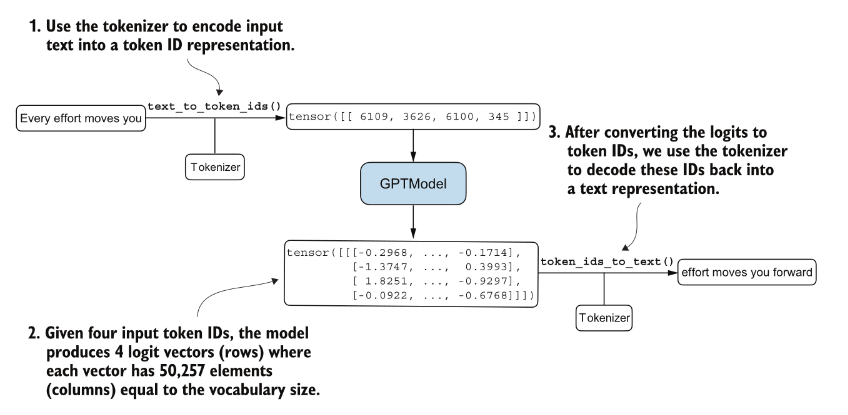

In [2]:
import tiktoken
from llm_architecture import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:", token_ids_to_text(token_ids, tokenizer))

Output text: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


we still get gibberish predictions. to get coherent text, we implement a numerical method to evaluate the generated content. this helps to monitor and enhance the model's performance throughout the training process.
next, we calculate a loss function which serves as a progress and success indicator of the training process.

In [3]:
inputs = torch.tensor([[16833, 3626, 6100], #["Every effort moves"]
                       [40, 1107, 588]]) # ["I really like."]

targets = torch.tensor([[3626, 6100, 345],   #["effort moves you"]
                        [1107, 588, 11311]])    #["really like chocolate."]

with torch.no_grad():
    logits = model(inputs)
    probs = torch.softmax(logits, dim=-1)
    print("Predicted probabilities shape:", probs.shape)  # Should be (2, 3, vocab_size)

Predicted probabilities shape: torch.Size([2, 3, 50257])


The first number, 2, corresponds to the two examples (rows) in the inputs, also known
as batch size. The second number, 3, corresponds to the number of tokens in each
input (row). Finally, the last number corresponds to the embedding dimensionality,
which is determined by the vocabulary size

In [4]:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print("Predicted token IDs:", token_ids) 

Predicted token IDs: tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [5]:
print((f"Targets batch 1: {token_ids_to_text(targets[0:1], tokenizer)}\n"))
print(f"Outout batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}\n")

Targets batch 1:  effort moves you

Outout batch 1:  Armed heNetflix



In [6]:
#eval
text_idx = 0
target_probs_1 = probs[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probs_1)

text_idx = 1
target_probs_2 = probs[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probs_2)

Text 1: tensor([0.0001, 0.0000, 0.0000])
Text 2: tensor([0.0000, 0.0001, 0.0000])


In [7]:
log_probs = torch.log(torch.cat([target_probs_1, target_probs_2]))
print("Log probabilities:", log_probs)

Log probabilities: tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7765, -12.2561])


In [8]:
# next we combine these log probabilities into a single score by computing the average.

average_log_probabilities = torch.mean(log_probs)
print("Average log probability", average_log_probabilities)

# the goal is to get the average log probability as close to 0 as possible by updating the model weights during training. I deep learning, our goal is to bring the -ve average log probability down to 0 by multiplying average_log_probabilities by -1.

neg_agerage_log_probability = average_log_probabilities * -1

print("Negative log probability", neg_agerage_log_probability)

Average log probability tensor(-10.7940)
Negative log probability tensor(10.7940)


In DL, the process of turning this -ve value -10.7940 to a +ve value is the the "cross entropy loss". However, this can also be computed in PyTorch.

In [9]:
# Before applying the cross entropy loss, we recall the shape of the logits and target tensors

print("Logits shape", logits.shape)
print("Target shape", targets.shape)

Logits shape torch.Size([2, 3, 50257])
Target shape torch.Size([2, 3])


the logits tensor has three dimensions: batch size, number of tokens,
and vocabulary size. The targets tensor has two dimensions: batch size and number of tokens.

In [10]:
# For the cross_entropy loss function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print("Flattened logits", logits_flat.shape)
print("Flattened targets", targets_flat.shape)

Flattened logits torch.Size([6, 50257])
Flattened targets torch.Size([6])


the targets are the token IDs we want the LLM to generate, and the
logits contain the unscaled model outputs before they enter the softmax function to obtain the probability scores.

In [11]:
# using pytorch, we can do all of the above steps

loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Perplexity is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling. it measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset. Similar to the loss, a lower preplexity indicates that the model predictions are closer to the actual distribution

In [12]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48726.5195)


Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. In the given example, this would translate to the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token.\n
We have calculated the loss for two small input texts. Now we apply the loss to the entire training and validation sets

In [13]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [14]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters in text: {total_characters}")
print(f"Total tokens in text: {total_tokens}")

Total characters in text: 20479
Total tokens in text: 5145


In [15]:
# next we divide the text data into training and validation sets using the dataloader from data_preparation.ipynb

train_ratio = 0.9
split_index = int(train_ratio * len(text_data))
train_data = text_data[:split_index]
val_data = text_data[split_index:]

In [16]:
from data_preparation import create_dataloaderv1
torch.manual_seed(123)

train_dataloader = create_dataloaderv1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
)
val_dataloader = create_dataloaderv1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
)

('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


In [17]:
# optionally, we can iterate through the dataloaders to ensure that they were created correctly

print("Train Loader:")
for x,y in train_dataloader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)

print("Validation Loader:")
for x,y in val_dataloader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)

Train Loader:
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Validation Loader:
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])


In [18]:
# utility function to compute cross entropy loss

def calculate_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)
    logits_flat = logits.flatten(0,1)
    targets_flat = target_batch.flatten()
    loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
    return loss

In [19]:
def calculate_loss_loader(dataloader, model, device, num_batches=None):
    total_loss = 0.0
    if len(dataloader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(dataloader)
    else:
        num_batches = min(num_batches, len(dataloader))
    for i, (input_batch, target_batch) in enumerate(dataloader):
        if i < num_batches:
            loss = calculate_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    train_loss = calculate_loss_loader(train_dataloader, model, device)
    
    val_loss = calculate_loss_loader(val_dataloader, model, device)
    
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Training Loss: 10.9876
Validation Loss: 10.9811


the loss values are currently high because we have not trained the model.
To train the model using GPTModel, we will use a simple training loop

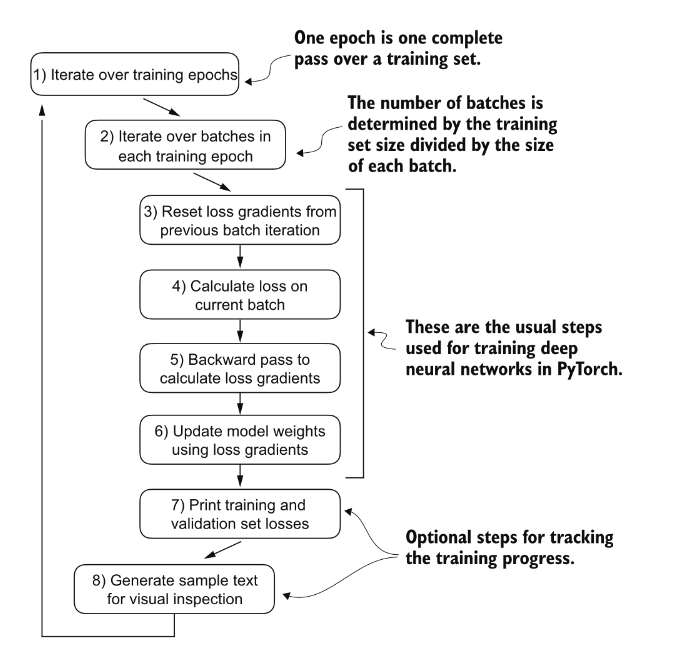

In [21]:
def evaluate_model(model, train_dataloader, val_dataloader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_loss_loader(
            train_dataloader, model, device, num_batches=eval_iter
        )
        val_loss = calculate_loss_loader(
            val_dataloader, model, device, num_batches=eval_iter
   
        )
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    print(decoded_text.replace("\n", " "))
    model.train()

In [22]:
def train_model_simple(model, train_dataloader, val_dataloader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            optimizer.zero_grad()
            loss = calculate_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_dataloader, val_dataloader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                      )
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen
                

the evaluate_model function is step 7 in the image above, it calculates the loss over the training and validation set while ensuring the model is in eval mode with gradient tracking and dropout disabled when calculating the loss over the training and validation sets

the generate_and_print_sample function takes a text snippet (start_context) as input, converts it into token IDs, and feeds it to the LLM to generate a text sample using the generate_text_simple function we used earlier:

While the evaluate_model function gives us a numeric estimate of the model’s training progress, this generate_and_print_sample text function provides a concrete text example generated by the model to judge its capabilities during training.

We will be using AdamW optimizer which is a variant of the usual Adam variant which improves the weight decay approach which minimizes model complexity and prevents overfitting by penalizing larger weights. This allows AdamW to achieve more effective regularization and better generalization

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device, num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

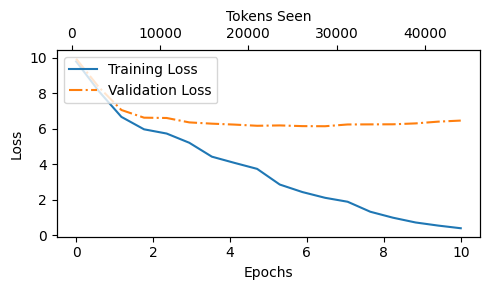

In [ ]:
# plotting the training and validation loss side by side
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label='Training Loss')
    ax1.plot(
        epochs_seen, val_losses, label='Validation Loss', linestyle='-.'
    )
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper left')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel('Tokens Seen')
    fig.tight_layout()
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The resulting training and validation loss plot is shown above. As we can see, both the training and validation losses start to improve for the first epoch. However, the losses start to diverge past the second epoch. This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfit
ting to the training data.

#### Decoding strategies to control randomness

In [ ]:
model.to('cpu')
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:", token_ids_to_text(token_ids, tokenizer))


Output text: Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


the generated token is selected at each generation step corre-
sponding to the largest probability score among all tokens in the vocabulary. This means that the LLM will always generate the same outputs even if we run the preceding generate_text_simple function multiple times on the same start context (Every effort moves you).

#### Temperature scaling:
this is a technique that adds a probabilistic selection process to the next-token generation task. in the generate_text_simple function, we would sample the token with the highest probablility as the next token using torch.argmax. to generate text with more variety, we can replace argmax with a function that samples from a distribution 

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
next_token_logits = torch.tensor((
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
))

In [ ]:
probs = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probs).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probs, num_samples=1).item()
print(inverse_vocab[next_token_id])


forward


In [ ]:
def print_sampled_tokens(probs):
    torch.manual_seed(123)
    sample = [torch.multinomial(probs, num_samples=1).item() for _ in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probs)
    

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


As we can see, the word forward is sampled most of the time (582 out of 1,000 times), but other tokens such as closer, inches, and toward will also be sampled some of the time. This means that if we replaced the argmax function with the multinomial function inside the generate_and_print_sample function, the LLM would sometimes generate texts such as every effort moves you toward, every effort moves you inches, and every effort moves you closer instead of every effort moves you forward.
We can further control the distribution and selection process via a concept called temperature scaling. Temperature scaling is just a fancy description for dividing the logits 
by a number greater than 0:

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

Temperatures > 1 will result in more uniformly distrubuted token probablilities and temperatures < 1 will result in more confident distributions. We can illustrate this by plotting the original probablilites alongside the probablilites with different temperature values.

/tmp/ipykernel_395370/589791732.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(vocab.keys(), rotation=90)


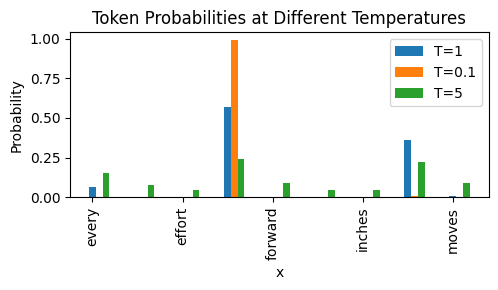

In [ ]:
temperatures = [1,0.1,5]

scaled_probabilities = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

x = torch.arange(len(vocab))

bar_width = 0.15

fig, ax = plt.subplots(figsize=(5,3))

for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probabilities[i], bar_width, label=f'T={T}')

ax.set_xlabel('x')
ax.set_ylabel('Probability')
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.set_title('Token Probabilities at Different Temperatures')
ax.legend()
plt.tight_layout()
plt.show()

As seen in the plot, spplying very small temperatures such as 0.1, will result in sharper distributions such that the behaviour of the multinomial function selects the most likely token (in this case, 'forward') almost all the time. A temp of 5 results in a more uniform distribution where other token are selected more often.

In [ ]:
print_sampled_tokens(scaled_probabilities[i])


165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


#### Top-k Sampling
We have seen that higher temperature values result in more uniformly distributed next-token probabilities, which result in more diverse outputs as it reduces the likelihood of the model repeatedly selecting the most probable token. This method allows for the exploring of less likely but potentially more interesting and creative paths in the generation process. However, one downside of this approach is that it sometimes leads to grammatically incorrect or completely nonsensical outputs such as every effort moves you pizza.

Top-k sampling when combined with probalilistic sampling and temperature scaling can improve the text generation results. In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores

the top-k approach replaces all nonselected logits with -ve infinity value (-inf), such that when computing the softmax values, the probability scores of the non-top-k tokens are 0 and the remaining probabilities sum up to 1.

In [ ]:
# selecting the tokens with the highest logit scores
top_k = 3

top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(top_logits)
print(top_pos)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [ ]:
# we apply PyTorch's where function to set the logit values of tokens that are below the lowest logit value withing our top-3 to -inf

new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(-float('inf')),
    other = next_token_logits
)
print(new_logits)

# we can now apply softmax to the new logits

topk_probabilities = torch.softmax(new_logits, dim=0)
print(topk_probabilities)


tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Modifying the text generation function with more diversity

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_value = top_logits[:, -1]
            logits = torch.where(
                logits < min_value,
                torch.tensor(float('-inf')).to(logits.device),
                logits,
            )
        if temperature > 0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=0.5,
    top_k=15,
)
print("Output text:\n ", token_ids_to_text(token_ids, tokenizer))


Output text:
  Every effort moves you know," was one of the axioms he laid down across the Sev


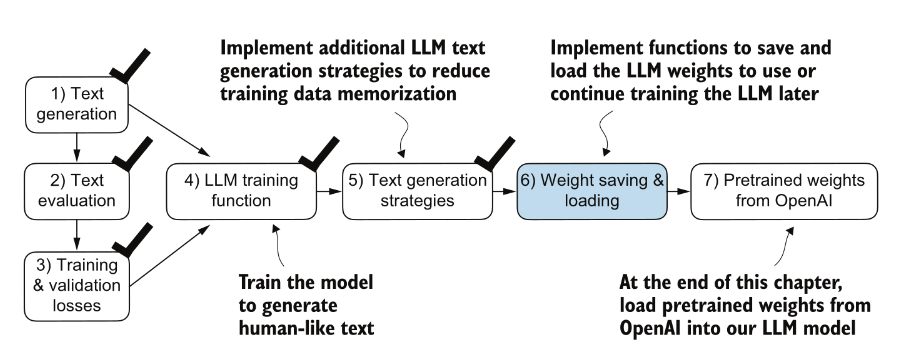

In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention

we recall that dropout helps prevent the model from overfitting to the
training data by randomly “dropping out” of a layer’s neurons during training. However, during inference, we don’t want to randomly drop out any of the information the network has learned. Using model.eval() switches the model to evaluation mode for inference, disabling the dropout layers of the model. If we plan to continue pre-training a model later—for example, using the train_model_simple function we defined earlier in this chapter—saving the optimizer state is also recommended.

Adaptive optimizers such as AdamW store additional parameters for each model weight. AdamW uses historical data to adjust learning rates for each model parameter dynamically. Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge properly, which means it will lose the ability to generate coherent text.

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
           "model_and_optimizer.pth"
           )

In [ ]:
# we can then load the model and parameter by first loading the saved data 

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) 
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (feedforward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention

Loading pretrained weights from openai

In [ ]:
# import urllib.request

# url = (
#     "https://raw.githubusercontent.com/rasbt/"
#     "LLMs-from-scratch/main/ch05/"
#     "01_main-chapter-code/gpt_download.py"
# )

# filename = url.split('/')[-1]
# urllib.request.urlretrieve(url, filename)

In [ ]:
# !pip install llms_from_scratch

  Using cached llms_from_scratch-1.0.17-py3-none-any.whl.metadata (15 kB)
  Using cached torch-2.9.1-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached tiktoken-0.12.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (6.7 kB)
  Using cached tensorflow-2.20.0-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached numpy-2.0.2.tar.gz (18.9 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... -^C
anceled
ERROR: Operation cancelled by user


In [ ]:
import torch
from 'LLMs-from-scratch.ch04' import GPTModel

GPT_CONFIG_BASE = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Original context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-medium (355M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_BASE.copy()
NEW_CONFIG.update(model_configs[model_name])

model = GPTModel(NEW_CONFIG)

# Option A: state dict
model.load_state_dict(torch.load("gpt2-medium-355M.pth", weights_only=True));
model.eval();

# Option B: safetensors
# from safetensors.torch import load_file
# model.load_state_dict(load_file("./gpt2/124M/gpt2-small-124M.safetensors"))

model.eval();


FileNotFoundError: [Errno 2] No such file or directory: 'gpt2-medium-355M.pth'

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
    model_size="124M", models_dir="gpt2"
)

2025-12-07 00:59:22.446419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 27.1kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 413kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 69.4kiB/s]
model.ckpt.data-00000-of-00001:   2%|▏         | 12.0M/498M [00:09<06:36, 1.22MiB/s]


KeyboardInterrupt: 

In [ ]:
print("Settings: ", settings)
print("Parameter dictionary keys: ", params.keys())

the settings dictionary stores the LLM architecture settings similarly to our manually defined GPT_CONFIG_124M settings.
the params dictionary contains the actual weight tensors.

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions: ", params["wte"].shape)